In [74]:
import textwrap

import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from scipy.stats import gmean, lognorm, norm, uniform

In [75]:
"""
Calculating the equivelant values of mean and multiplication uncertainty factor,
that are represeting a lognormal distribution of uncertinaty similar to the given
normal uncertianty distirbution
"""


def mul_err_equiv(
    val,
    lin_err,
    n=1000,
):
    if np.isnan(lin_err):
        if np.isnan(val):
            return np.nan, np.nan
        else:
            return val, 1
    rvs = norm(val, lin_err).rvs(n)
    params = lognorm.fit(rvs[rvs > 0], floc=0)
    return params[2], np.exp(params[0])


"""
Each column is uncertainty factors of another variable
"""


def unc_of_mul(unc_facs_arr):
    log_unc_facs = np.log(unc_facs_arr)
    return np.exp((log_unc_facs**2).sum(axis=1) ** 0.5)

Loading general data regarding the properties of cfDNA and plasma, and combining it with the estiamtes for cfDNA plasma concentration from .. to get a reference plasma concentration

In [76]:
cfd_gen_data_df = pd.read_excel('data.xlsx', sheet_name='general_data', index_col=0)

The total concenctration is taken from [Meddeb et al. 2019](https://www.nature.com/articles/s41598-019-41593-4). 
The estiamtes for the median of the young group is taken to be the norm with the uncertianty of the median converted to lognormal terms.

Moreover, we consider additional variation caused by the hour/day of measurment and by the analytical assays, estiamted in [Madsen et al. 2019](https://www.thelancet.com/journals/ebiom/article/PIIS2352-3964(19)30672-3). We use the combined coefficient of variation defined as: "within individuals" and "analytic".

All uncertinaties are calculated in 1 sigma

In [77]:
tot_cfd_conc_df = pd.read_excel('data.xlsx', sheet_name="cfDNA_conc_Meddeb_2019", index_col=0)
tot_cfd_conc_df

description    N  median  min   max  \
population                                                          
all                   healthy individuals  104    1650  110  7000   
males            male healthy individuals   62    1690  150  7000   
females        female healthy individuals   42    1490  110  4000   
young       under 47y healthy individuals   52    1360  110  4400   
old          over 47y healthy individuals   52    1730  300  7000   

            95%_CI_median_lower  95%_CI_median_upper  mean  sem  \
population                                                        
all                        1440                 1750  1790  110   
males                      1490                 2060  1950  150   
females                     990                 1670  1540  160   
young                      1040                 1670  1540  140   
old                        1640                 2200  2040  160   

                         units  
population                      
all         copy number per ml  
males       copy number per ml  
females     copy number per ml  
young       copy number per ml  
old         copy number per ml

In [78]:
median_95_sigma_group = (tot_cfd_conc_df.loc['young', '95%_CI_median_upper'] - tot_cfd_conc_df.loc['young', '95%_CI_median_lower'])/4
tot_GE_ml, group_unc_fac = mul_err_equiv(tot_cfd_conc_df.loc['young', 'median'], median_95_sigma_group)
tot_GE_ml.round(-1)

1360.0

In [79]:
unc_cfd_conc_df = pd.read_excel('data.xlsx', sheet_name="conc_variaion_Madsen_2019", index_col=0)
unc_cfd_conc_df

B2M  EIF2C1  RNaseP    TERT  geomean
type of CV                                                           
analytic                     6.6e-02 6.4e-02 8.4e-02 6.6e-02  7.0e-02
within subject               2.4e-01 2.4e-01 2.5e-01 2.3e-01  2.4e-01
between subject              2.6e-01 3.0e-01 2.7e-01 3.0e-01  2.8e-01
between days within subject  2.1e-01 2.3e-01 2.3e-01 2.2e-01  2.2e-01
between days between subject 3.0e-01 3.4e-01 3.2e-01 3.4e-01  3.2e-01
within day within subject    2.3e-01 2.4e-01 2.4e-01 2.7e-01  2.5e-01
within day between subject   2.3e-01 2.7e-01 2.5e-01 2.8e-01  2.5e-01

In [80]:
cv_within_and_analytic = np.sqrt(
    unc_cfd_conc_df.loc["within subject", "geomean"] ** 2
    + unc_cfd_conc_df.loc["analytic", "geomean"] ** 2
)
_, within_and_analytic_unc_fac = mul_err_equiv(1, cv_within_and_analytic)

In [81]:
# we use the unc_of_mul funcion which works on 2d vectors / dataframe, so we make some adjustment
tot_GE_ml_unc_fac = unc_of_mul(np.array([[group_unc_fac, within_and_analytic_unc_fac]]))[0]
tot_GE_ml_unc_fac.round(2)

1.34

In [82]:
save_dir = "Figures"
mpl.style.use("seaborn-v0_8-whitegrid")
sns.set_style("whitegrid")
rc_pars = {
    "legend.facecolor": "white",
    "legend.framealpha": 0.85,
    "lines.linewidth": 3,
    "legend.edgecolor": "Black",
    "legend.frameon": True,
    "legend.fancybox": True,
    "legend.shadow": False,
    "figure.figsize": [10, 7],
    "figure.dpi": 300,
}
sns.set_context("talk", rc=rc_pars)

Adding a factor for the possible short fragments not accounted in Meddeb et al.
We use values from [Hisano et al. 2021](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8518174/) assuming this leads to a uniform factor in the range of 1-2, where the maximum value is when assuming that similar molar concentration implies similar number of genome equivalents

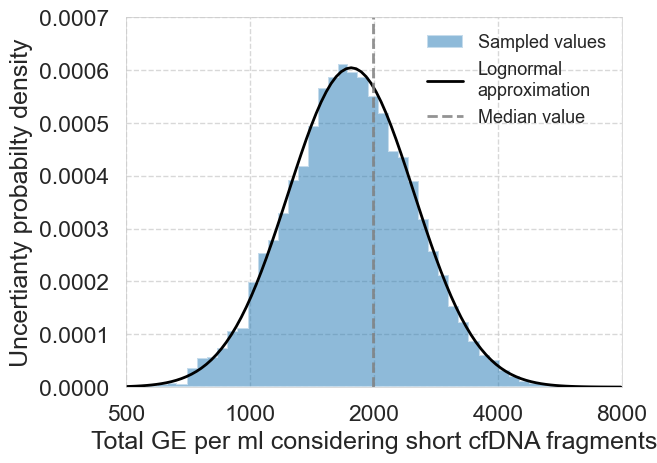

In [83]:
short_frags_range = cfd_gen_data_df.loc[
    "factor for small fragments",
    ["lower_bound", "upper_bound"],
].to_list()
short_frags_fac_dist = uniform(
    loc=short_frags_range[0],
    scale=short_frags_range[1] - short_frags_range[0],
)
GE_ml_dist = lognorm(
    s=np.log(tot_GE_ml_unc_fac),
    scale=tot_GE_ml,
)

N = 10000
mul_rvs = short_frags_fac_dist.rvs(N) * GE_ml_dist.rvs(N)
params = lognorm.fit(mul_rvs, floc=0)
mul_dist = lognorm(s=params[0], scale=params[2])


ax = plt.subplot()
ax.hist(
    mul_rvs,
    bins=np.logspace(2.7, 3.9),
    histtype="stepfilled",
    alpha=0.5,
    density=True,
    label="Sampled values",
)
ax.set_xscale("log")
ax.set_xticks(
    ticks=[500, 1000, 2000, 4000, 8000],
    labels=[500, 1000, 2000, 4000, 8000],
)
ax.set_xlim(500, 8000)
ax.grid(
    ls="--",
    alpha=0.75,
    lw=1,
)
xx = np.logspace(2.7, 3.9, 100)
ax.plot(
    xx,
    mul_dist.pdf(xx),
    label="Lognormal\napproximation",
    lw=2,
    color="k",
)
ax.set_xlabel("Total GE per ml considering short cfDNA fragments")
ax.set_ylabel("Uncertianty probabilty density")

for side in ["top", "bottom", "left", "right"]:
    ax.spines[side].set(lw=0.5)

mul_mode = mul_dist.kwds["scale"] / np.exp(mul_dist.kwds["s"] ** 2)
max_val = np.ceil(mul_dist.pdf(mul_mode) * 10**4) / 10**4
ax.vlines(
    params[2],
    ymin=0,
    ymax=max_val,
    color="grey",
    alpha=0.85,
    ls="--",
    lw=2,
    label="Median value",
)
ax.set_ylim(0, max_val)

ax.legend(loc="upper right", fontsize=13)

Adjusting the estimates for the total concentrations:

In [52]:
tot_GE_ml = params[2]
tot_GE_ml_unc_fac = np.exp(params[0])

Loading the fractions of cfDNA for different cell types (grouped for some)

In [53]:
cfdna_fracs = pd.read_excel("data.xlsx", sheet_name="fractions", index_col=0)
cfdna_fracs["tot_conc"] = (
    tot_GE_ml
    * cfdna_fracs.fraction
    * cfd_gen_data_df.value["haploid genome equivalent"]
)
cfdna_fracs["tot_conc_unc_fac"] = tot_GE_ml_unc_fac
cfdna_fracs

fraction  sd      comment    color  tot_conc  \
cell_type                                                               
erythrocytes              6.0e-02 NaN  progenitors  #9c0000   3.9e-10   
monocytes / macrophages   1.9e-01 NaN          NaN  #a16969   1.2e-09   
megakaryocytes            2.7e-01 NaN          NaN  #f29b8a   1.8e-09   
granulocytes              3.2e-01 NaN          NaN  #e69696   2.1e-09   
hepatocytes               2.0e-02 NaN          NaN  #b68d52   1.3e-10   
endothelial cells         7.0e-02 NaN          NaN  #d9cb4a   4.6e-10   
lymphocytes               4.0e-02 NaN          NaN  #a63c51   2.6e-10   
other                     2.0e-02 NaN          NaN      NaN   1.3e-10   

                         tot_conc_unc_fac  
cell_type                                  
erythrocytes                      1.4e+00  
monocytes / macrophages           1.4e+00  
megakaryocytes                    1.4e+00  
granulocytes                      1.4e+00  
hepatocytes                       1.4e+00  
endothelial cells                 1.4e+00  
lymphocytes                       1.4e+00  
other                             1.4e+00

Loading the data of daily cellular turnover based on Sender & Milo, 2021 
(hepatocytes according Heinke et al. 2022)
and grouping the relevant cell types for which there is cfDNA data

In [54]:
turnover_df = pd.read_excel("data.xlsx", sheet_name="daily_turnover", index_col=0)
turnover_df = turnover_df.rename(
    columns={
        "cellular turnover rate (10^12/d)": "mean_to",
        "delta low turnover rate (10^12/d)": "low_to",
        "delta high turnover rate (10^12/d)": "hi_to",
    }
)
turnover_df = turnover_df[turnover_df["based on mouse"] == 0]
turnover_df = turnover_df.loc[
    turnover_df.group.isin(set(cfdna_fracs.index) - {"other"})
]
turnover_df = turnover_df[
    [
        "trillion_of_cells",
        "number_delta",
        "number_upper",
        "group",
        "mean_to",
        "low_to",
        "hi_to",
    ]
]
turnover_df["unc_type"] = turnover_df.apply(
    lambda row: "linear" if row.low_to == row.hi_to else "mul", axis=1
)
turnover_df["unc_fac"] = turnover_df.apply(
    lambda row: row.low_to
    if row.unc_type == "linear"
    else ((row.mean_to + row.hi_to) / (row.mean_to - row.low_to)) ** 0.5,
    axis=1,
)

A function for calculating the uncertainty when adding variables with possible logarithmic uncertainty

In [55]:
"""
arr - array 3xn with row for each value added. Each with mean, uncertainty type and uncertainty factor
"""


def unc_of_add(arr, n_iterations=1000):
    results = pd.Series(index=['mean', 'unc'])
    n_var = arr.shape[0]
    if n_var == 1:
        if arr[0, 1] == "linear":
            results[:] = mul_err_equiv(arr[0, 0], arr[0, 2])
        else:
            results[:] = arr[0, 0], arr[0, 2]
    else:
        dists = [
            norm(arr[i, 0], arr[i, 2])
            if arr[i, 1] == "linear"
            else lognorm(scale=arr[i, 0], s=np.log(arr[i, 2]))
            for i in range(arr.shape[0])
        ]
        x = np.zeros([n_iterations, n_var])
        for i in range(arr.shape[0]):
            dist = (
                norm(arr[i, 0], arr[i, 2])
                if arr[i, 1] == "linear"
                else lognorm(scale=arr[i, 0], s=np.log(arr[i, 2]))
            )
            x[:, i] = dist.rvs(n_iterations)
        fit_params = lognorm.fit(x.sum(axis=1), floc=0)
        results[:] = fit_params[2], np.exp(fit_params[0])
    return results

In [56]:
turnover_df = (
    turnover_df.groupby("group")
    .apply(
        lambda x: unc_of_add(x[["mean_to", "unc_type", "unc_fac"]].values),
    )
    .rename(columns={"mean": "mean_to", "unc": "to_unc_fac"})
)
turnover_df["color"] = cfdna_fracs.color
turnover_df

mean_to  to_unc_fac    color
group                                                
endothelial cells        2.2e-04     2.2e+00  #d9cb4a
erythrocytes             2.1e-01     1.1e+00  #9c0000
granulocytes             5.8e-02     1.3e+00  #e69696
hepatocytes              4.4e-04     2.6e+00  #b68d52
lymphocytes              8.5e-03     2.1e+00  #a63c51
megakaryocytes           8.1e-05     1.4e+00  #f29b8a
monocytes / macrophages  1.8e-03     1.8e+00  #a16969

In [57]:
"""
"""


def bounds_to_mul_unc(tup):
    vals, lows, ups = tup
    return gmean([ups / vals, vals / lows])

Loading the DNA per cell data and integrating it to calculate the nuclei turnover in GE per day

In [58]:
dna_per_cell_df = pd.read_excel("data.xlsx", sheet_name="DNA_per_cell", index_col=0)
turnover_df = turnover_df.join(
    dna_per_cell_df.loc[turnover_df.index].fillna(0).apply(
        lambda row: pd.Series(
            mul_err_equiv(row.Ploidy, row["sem"]),
            index=["dna_per_cell", "dna_pc_unc_fac"],
        ),
        axis=1,
    )
)
turnover_df["GE_per_day"] = turnover_df.mean_to * turnover_df.dna_per_cell * 10**12
turnover_df["GE_per_day_unc_fac"] = unc_of_mul(
    turnover_df[["to_unc_fac", "dna_pc_unc_fac"]]
)
turnover_df

mean_to  to_unc_fac    color  dna_per_cell  \
group                                                                 
endothelial cells        2.2e-04     2.2e+00  #d9cb4a       2.0e+00   
erythrocytes             2.1e-01     1.1e+00  #9c0000       2.0e+00   
granulocytes             5.8e-02     1.3e+00  #e69696       2.0e+00   
hepatocytes              4.4e-04     2.6e+00  #b68d52       2.5e+00   
lymphocytes              8.5e-03     2.1e+00  #a63c51       2.0e+00   
megakaryocytes           8.1e-05     1.4e+00  #f29b8a       1.6e+01   
monocytes / macrophages  1.8e-03     1.8e+00  #a16969       2.0e+00   

                         dna_pc_unc_fac  GE_per_day  GE_per_day_unc_fac  
group                                                                    
endothelial cells               1.0e+00     4.4e+08             2.2e+00  
erythrocytes                    1.0e+00     4.3e+11             1.1e+00  
granulocytes                    1.0e+00     1.2e+11             1.3e+00  
hepatocytes                     1.0e+00     1.1e+09             2.6e+00  
lymphocytes                     1.0e+00     1.7e+10             2.1e+00  
megakaryocytes                  1.2e+00     1.3e+09             1.4e+00  
monocytes / macrophages         1.0e+00     3.6e+09             1.8e+00

Hepatocytes special case - we use the results from Heinke et al. who created a model for the turnover of hepatocytes as a function of their ploidy

In [59]:
hep_to_df = pd.read_excel(
    "data.xlsx",
    sheet_name="Hepatocytes_turnover",
    index_col=0,
    skiprows=1,
    skipfooter=1,
)
hep_to_df["nuc_daily_to"] = hep_to_df.daily_cellular_turnover * hep_to_df.polidy
hep_to_df["nuc_daily_to_lower"] = hep_to_df.lower_daily_turnover * hep_to_df.polidy
hep_to_df["nuc_daily_to_upper"] = hep_to_df.upper_daily_turnover * hep_to_df.polidy
sum_hep_df = hep_to_df.sum()
turnover_df.loc["hepatocytes", "GE_per_day"] = sum_hep_df.nuc_daily_to
turnover_df.loc["hepatocytes", "GE_per_day_unc_fac"] = (
    sum_hep_df.nuc_daily_to_upper / sum_hep_df.nuc_daily_to_lower
) ** 0.5
turnover_df

mean_to  to_unc_fac    color  dna_per_cell  \
group                                                                 
endothelial cells        2.2e-04     2.2e+00  #d9cb4a       2.0e+00   
erythrocytes             2.1e-01     1.1e+00  #9c0000       2.0e+00   
granulocytes             5.8e-02     1.3e+00  #e69696       2.0e+00   
hepatocytes              4.4e-04     2.6e+00  #b68d52       2.5e+00   
lymphocytes              8.5e-03     2.1e+00  #a63c51       2.0e+00   
megakaryocytes           8.1e-05     1.4e+00  #f29b8a       1.6e+01   
monocytes / macrophages  1.8e-03     1.8e+00  #a16969       2.0e+00   

                         dna_pc_unc_fac  GE_per_day  GE_per_day_unc_fac  
group                                                                    
endothelial cells               1.0e+00     4.4e+08             2.2e+00  
erythrocytes                    1.0e+00     4.3e+11             1.1e+00  
granulocytes                    1.0e+00     1.2e+11             1.3e+00  
hepatocytes                     1.0e+00     9.1e+08             2.6e+00  
lymphocytes                     1.0e+00     1.7e+10             2.1e+00  
megakaryocytes                  1.2e+00     1.3e+09             1.4e+00  
monocytes / macrophages         1.0e+00     3.6e+09             1.8e+00

In [60]:
turnover_df["g_DNA_per_day"] = (
    turnover_df.GE_per_day * cfd_gen_data_df.value["haploid genome equivalent"]
)
cfdna_lifespan = cfd_gen_data_df.value["lifespan of cfDNA in blood"] / np.log(2)
cfdna_lifespan_unc_fac = bounds_to_mul_unc(
    cfd_gen_data_df.loc[
        "lifespan of cfDNA in blood", ["value", "lower_bound", "upper_bound"]
    ]
)
plasma_volume = cfd_gen_data_df.value["plasma volume"]
plasma_volume_unc_fac = 1
turnover_df["eff_cfDNA_potential"] = (
    turnover_df.g_DNA_per_day * cfdna_lifespan / 24 / plasma_volume
)  # in g DNA per ml at a given moment (=per half-life of cfDNA)
turnover_df["eff_cfDNA_unc"] = unc_of_mul(
    np.vstack(
        (
            turnover_df["GE_per_day_unc_fac"].values,
            cfdna_lifespan_unc_fac * np.ones(turnover_df.shape[0]),
            plasma_volume_unc_fac * np.ones(turnover_df.shape[0]),
        )
    ).T
)


turnover_df["measured_cfDNA"] = cfdna_fracs.tot_conc
turnover_df["measured_cfDNA_unc_fac"] = cfdna_fracs.tot_conc_unc_fac

turnover_df["ratio"] = turnover_df.measured_cfDNA / turnover_df.eff_cfDNA_potential
turnover_df["ration_unc_fac"] = unc_of_mul(
    turnover_df[["eff_cfDNA_unc", "measured_cfDNA_unc_fac"]]
)
pd.set_option("display.float_format", "{:.1e}".format)
turnover_df

mean_to  to_unc_fac    color  dna_per_cell  \
group                                                                 
endothelial cells        2.2e-04     2.2e+00  #d9cb4a       2.0e+00   
erythrocytes             2.1e-01     1.1e+00  #9c0000       2.0e+00   
granulocytes             5.8e-02     1.3e+00  #e69696       2.0e+00   
hepatocytes              4.4e-04     2.6e+00  #b68d52       2.5e+00   
lymphocytes              8.5e-03     2.1e+00  #a63c51       2.0e+00   
megakaryocytes           8.1e-05     1.4e+00  #f29b8a       1.6e+01   
monocytes / macrophages  1.8e-03     1.8e+00  #a16969       2.0e+00   

                         dna_pc_unc_fac  GE_per_day  GE_per_day_unc_fac  \
group                                                                     
endothelial cells               1.0e+00     4.4e+08             2.2e+00   
erythrocytes                    1.0e+00     4.3e+11             1.1e+00   
granulocytes                    1.0e+00     1.2e+11             1.3e+00   
hepatocytes                     1.0e+00     9.1e+08             2.6e+00   
lymphocytes                     1.0e+00     1.7e+10             2.1e+00   
megakaryocytes                  1.2e+00     1.3e+09             1.4e+00   
monocytes / macrophages         1.0e+00     3.6e+09             1.8e+00   

                         g_DNA_per_day  eff_cfDNA_potential  eff_cfDNA_unc  \
group                                                                        
endothelial cells              1.4e-03              1.4e-08        2.8e+00   
erythrocytes                   1.4e+00              1.4e-05        2.0e+00   
granulocytes                   3.8e-01              3.9e-06        2.1e+00   
hepatocytes                    3.0e-03              3.0e-08        3.3e+00   
lymphocytes                    5.6e-02              5.6e-07        2.8e+00   
megakaryocytes                 4.4e-03              4.4e-08        2.2e+00   
monocytes / macrophages        1.2e-02              1.2e-07        2.5e+00   

                         measured_cfDNA  measured_cfDNA_unc_fac   ratio  \
group                                                                     
endothelial cells               4.6e-10                 1.4e+00 3.2e-02   
erythrocytes                    3.9e-10                 1.4e+00 2.8e-05   
granulocytes                    2.1e-09                 1.4e+00 5.4e-04   
hepatocytes                     1.3e-10                 1.4e+00 4.3e-03   
lymphocytes                     2.6e-10                 1.4e+00 4.6e-04   
megakaryocytes                  1.8e-09                 1.4e+00 4.0e-02   
monocytes / macrophages         1.2e-09                 1.4e+00 1.0e-02   

                         ration_unc_fac  
group                                    
endothelial cells               3.0e+00  
erythrocytes                    2.2e+00  
granulocytes                    2.3e+00  
hepatocytes                     3.5e+00  
lymphocytes                     3.0e+00  
megakaryocytes                  2.4e+00  
monocytes / macrophages         2.7e+00

In [61]:
def get_errorbar_array(vals, unc_facs):
    low_bars = (1 - 1 / unc_facs) * vals
    hi_bars = (unc_facs - 1) * vals
    return np.vstack((low_bars, hi_bars))

In [62]:
turnover_df = turnover_df.rename(index={'erythrocytes': 'erythrocytes progenitors'})

In [63]:
def format(f):
    p = round(f * 100, 10)
    return f"{int(p)}%" if p == int(p) else f"{p}%"

## Limit of detection

In [64]:
shedding_out = [
    "Small intestine  ",
    "Large intestine  ",
    "Skin",
    "Lungs, bronchi, bronchioles ",
    "Stomach ",
]

In [66]:
mto = pd.read_excel("data.xlsx", sheet_name="more_turnover", index_col=2)
mto["non_human"] = mto["cellular turnover [10^12 cell/d]"].isnull()
to_col = "cellular turnover [10^12 cell/d]"
to_sem_col = "SEM cellular turnover [10^12 cell/d]"
mto = mto.join(mto[[to_col, to_sem_col]].apply(
    lambda row: pd.Series(
        mul_err_equiv(row[to_col], row[to_sem_col]),
        index=["to", "to_unc_fac"],
    ),
    axis=1,
).mul(1 - mto.non_human,axis=0))

mto["Source for turnover"] = mto.non_human.map({True: "Non-human", False: "Human"})
mto.ploidy = mto.ploidy.fillna(2)
mto["nuc_to"] = mto.to * mto.ploidy / 2
mto["shed_out"] = (
    mto["Organ/system"]
    .map(dict(zip(shedding_out, [True] * len(shedding_out))))
    .fillna(False)
)
mto = mto.sort_values("nuc_to", ascending=False)

nuc_tunover2cfDNA_pot_factor = 2 * 10**12 * cfdna_lifespan / 24 / plasma_volume
mto["cfDNA_pot_hge"] = mto.nuc_to * nuc_tunover2cfDNA_pot_factor
mto["cfDNA_pot_unc"] = unc_of_mul(
    mto[["to_unc_fac"]].join(
        pd.DataFrame(
            cfdna_lifespan_unc_fac * np.ones_like(mto.to_unc_fac), index=mto.index
        )
    )
)
mto_h = mto[~mto.non_human]

hge = cfd_gen_data_df.value["haploid genome equivalent"]

In [67]:
def agg_unc_fac(df, cols=["val", "err"]):
    output = pd.Series(dtype=float, index=cols)
    df2 = df.loc[~df[cols[0]].isnull()]
    if df2.shape[0] > 0:
        df2["unc_type"] = "mul"
        output[:] = unc_of_add(df2[[cols[0], "unc_type", cols[1]]].values)
    return output

In [68]:
mto_h.groupby("Group").apply(
    lambda df: agg_unc_fac(df, cols=["cfDNA_pot_hge", "cfDNA_pot_unc"])
)

cfDNA_pot_hge  cfDNA_pot_unc
Group                                                 
endothelial cells               4.4e+03        2.8e+00
erythrocytes progenitors        4.3e+06        2.0e+00
granulocytes                    1.2e+06        2.0e+00
hepatocytes                     8.0e+03        3.0e+00
lymphocytes                     1.5e+05        2.2e+00
megakaryocytes                  1.3e+04        2.1e+00
monocytes / macrophages         3.3e+04        2.6e+00

In [84]:
mto_h2 = mto_h[mto_h.Group.isnull()]
summed_columns = [
    "trillion_cells",
    "cellular turnover [10^12 cell/d]",
    "nuc_to",
]
other_columns = ["Organ/system", "Tissue", "shed_out"]

agg_dict = {
    **dict(zip(summed_columns, ["sum"] * len(summed_columns))),
    **dict(zip(other_columns, [lambda x: x[0]] * len(other_columns))),
}
mto_h_measured = (
    mto_h[["Group"] + other_columns + summed_columns].groupby("Group").agg(agg_dict)
)
mto_h_measured["measured_cfDNA_hge"] = turnover_df["measured_cfDNA"] / hge
mto_h_measured["measured_cfDNA_unc"] = turnover_df.measured_cfDNA_unc_fac
mto_h_measured = mto_h_measured.join(
    mto_h.groupby("Group").apply(
        lambda df: agg_unc_fac(df, cols=["cfDNA_pot_hge", "cfDNA_pot_unc"])
    )
)

mto_h_measured.index = mto_h_measured.index.str.capitalize()

mto_h_measured = pd.concat([mto_h2, mto_h_measured])

mto_h_measured = mto_h_measured.sort_values("cfDNA_pot_hge", ascending=False)

mto_h_measured["order"] = np.arange(mto_h_measured.shape[0])
only_measured = mto_h_measured[~mto_h_measured.measured_cfDNA_hge.isnull()].copy()

z_value = 1.96
only_measured["top"] = (
    only_measured.cfDNA_pot_hge
    - get_errorbar_array(
        only_measured.cfDNA_pot_hge, only_measured.cfDNA_pot_unc**z_value
    )[0, :]
)
only_measured["bottom"] = (
    only_measured.measured_cfDNA_hge
    + get_errorbar_array(
        only_measured.measured_cfDNA_hge, only_measured.measured_cfDNA_unc**z_value
    )[1, :]
)


only_measured["y_mid"] = np.sqrt(
    only_measured.measured_cfDNA_hge * only_measured.cfDNA_pot_hge
)

at_third = ["Erythrocytes progenitors", "Hepatocytes"]
only_measured.loc[only_measured.index.isin(at_third), "y_mid"] = (
    only_measured.measured_cfDNA_hge**2 * only_measured.cfDNA_pot_hge
) ** (1 / 3)
only_measured["ratio"] = only_measured.measured_cfDNA_hge / only_measured.cfDNA_pot_hge
only_measured["ratio_unc"] = unc_of_mul(
    only_measured[["measured_cfDNA_unc", "cfDNA_pot_unc"]]
)


def format_lab(f):
    z = np.floor(np.log10(f)) + 2
    p = round(10 ** np.mod(np.log10(f), 1), 0)
    if p == 10:
        p = 1
        z += 1
    if z >= 0:
        return "{:0.0%}".format(f)
    else:
        return "0.{}{:0.0f}%".format("0" * int(np.abs(z) - 1), p)


only_measured["ratio_labels"] = only_measured["ratio"].map(format_lab)

C:\Users\Ron Sender\AppData\Local\Temp\ipykernel_20184\391790371.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  **dict(zip(other_columns, [lambda x: x[0]] * len(other_columns))),


In [70]:
def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    (line,) = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    z[:, :, -1] = np.linspace(0, alpha, 100)[:, None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(
        z, aspect="auto", extent=[xmin, xmax, ymin, ymax], origin="lower", zorder=zorder
    )

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor="none", edgecolor="none", closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

In [71]:
deconv_limit = 0.001
detec_limit_hge =tot_GE_ml*deconv_limit

## Figure

In [85]:
plt.figure(figsize=(14, 10))
ax = plt.gca()
mono_color = "black"
alpha = 0.85
ax.scatter(
    x=mto_h_measured.index,
    y=mto_h_measured.cfDNA_pot_hge
    * mto_h_measured.shed_out.map({True: np.nan, False: 1}),
    color=mono_color,
    s=200,
    label="Not being shed",
    alpha=1,
    zorder=3,
)
ax.scatter(
    x=mto_h_measured.index,
    y=mto_h_measured.cfDNA_pot_hge
    * mto_h_measured.shed_out.map({True: 1, False: np.nan}),
    facecolor="w",
    lw=3,
    color=mono_color,
    s=200,
    label="Being shed",
    alpha=1,
    zorder=3,
)

error_bar_kws = dict(
    ls="none",
    lw=2.5,
    zorder=2,
    marker="",
    color="grey",
    capsize=4,
    capthick=1.5,
    elinewidth=1.5,
    alpha=0.85,
)


yerr = get_errorbar_array(
    mto_h_measured.cfDNA_pot_hge, mto_h_measured.cfDNA_pot_unc**z_value
)
eb = ax.errorbar(
    x=mto_h_measured.index,
    y=mto_h_measured.cfDNA_pot_hge,
    yerr=yerr,
    **error_bar_kws,
)
eb[-1][0].set_linestyle("--")

x_delta = 0.25
ax.scatter(
    x=mto_h_measured.index,
    y=mto_h_measured.measured_cfDNA_hge,
    color=mono_color,
    s=150,
    label="measured",
    marker="D",
    zorder=3,
    alpha=1,
)

yerr = get_errorbar_array(
    mto_h_measured.measured_cfDNA_hge, mto_h_measured.measured_cfDNA_unc**z_value
)
eb = ax.errorbar(
    x=mto_h_measured.index,
    y=mto_h_measured.measured_cfDNA_hge,
    yerr=yerr,
    **error_bar_kws,
)
eb[-1][0].set_linestyle("--")

ratio_color = "seagreen"
bbox = dict(boxstyle="round", ec=ratio_color, fc="w")
arrowprops = dict(
    arrowstyle="<|-|>",
    connectionstyle="arc3",
    lw=2.5,
    color=ratio_color,
    shrinkA=2,
    shrinkB=2,
)
for index, row in only_measured[::-1].iterrows():
    ax.annotate(
        "",
        xy=(row.order - x_delta, row.measured_cfDNA_hge),
        xycoords="data",
        xytext=(row.order - x_delta, row.cfDNA_pot_hge),
        textcoords="data",
        arrowprops=arrowprops,
    )

    ax.text(
        row.order - x_delta,
        row.y_mid,
        s=row.ratio_labels,
        color=ratio_color,
        fontsize=16,
        ha="center",
        va="center",
        bbox=bbox,
    )


xlim = (-1.2, mto_h_measured.shape[0] - 0.2)
ax.text(
    x=mto_h_measured.shape[0] / 2,
    y=1.5 * detec_limit_hge,
    s="Detection limit",
    color="k",
    alpha=0.75,
    zorder=10,
    fontsize=17.5,
)
fill_color = "grey"
z = np.empty((100, 1, 4), dtype=float)
alpha = 1
rgb = mcolors.colorConverter.to_rgb(fill_color)
z[:, :, :3] = rgb
z[:, :, -1] = np.logspace(np.log10(alpha), -2, 100)[:, None]
im = ax.imshow(
    z,
    aspect="auto",
    extent=[xlim[0], xlim[1], 0.1 * detec_limit_hge, 10 * detec_limit_hge],
    origin="lower",
    zorder=1,
)


ax.set_yscale("log")
# ax.set_xticklabels(labels=mto_h_measured.index, rotation=90)
ax.set_xticks(
    np.arange(mto_h_measured.shape[0]+1) - 0.5, labels=[""] * (1+mto_h_measured.shape[0])
)
ax.set_xticks(
    np.arange(mto_h_measured.shape[0]),
    minor=True,
    labels= mto_h_measured.index.to_list(),
    rotation=90,
)


ax.set_ylabel("cfDNA [Genome Equivalents/ml]")
ax.set_xlabel("Cell type - ordered by cellular turnover")
ax.set_xlim(xlim)
ylim_powers = np.array([-0.1, 7.5])
ax.set_ylim(10**ylim_powers)

###
# Creating a "special legend"
###
leg_font_size = 15
x_for_leg = xlim[1] - 2.3
y_legs = [10**6.83, 10**4]
ax.scatter(
    [x_for_leg],
    [y_legs[0]],
    marker="o",
    color=mono_color,
    s=200,
    zorder=4,
    alpha=alpha,
)
ax.scatter(
    [x_for_leg],
    [y_legs[1]],
    marker="D",
    color=mono_color,
    s=150,
    zorder=4,
    alpha=alpha,
)
ax.annotate(
        "",
        xy=(x_for_leg - x_delta, y_legs[0]),
        xycoords="data",
        xytext=(x_for_leg - x_delta, y_legs[1]),
        textcoords="data",
        arrowprops=arrowprops,
    )


ax.text(
    x_for_leg - x_delta,
    np.sqrt(y_legs[0] * y_legs[1]),
    s="Ratio",
    color=ratio_color,
    fontsize=leg_font_size,
    ha="center",
    va="center",
    bbox=bbox,
    zorder=5,
)
ax.text(
    x_for_leg,
    y_legs[0] * 1.5,
    s="Potential",
    color=mono_color,
    ha="center",
    va="bottom",
    fontsize=leg_font_size,
    alpha=alpha,
)
ax.text(
    x_for_leg,
    y_legs[1] / 1.5,
    s="Observed",
    color=mono_color,
    ha="center",
    va="top",
    fontsize=leg_font_size,
    alpha=alpha,
)
rect = patches.Rectangle(
    (x_for_leg - 7.5, y_legs[1] / 10),
    10,
    10**7.5,
    linewidth=1,
    edgecolor="none",
    facecolor="w",
    alpha=0.8,
    zorder=1,
)
ax.add_patch(rect)
handles2 = [
    Line2D(
        [0],
        [0],
        ls="none",
        marker="o",
        color=mono_color,
        markersize=15,
        mew=2.5,
        mfc="w",
        alpha=alpha,
    )
]
labels2 = ["Being shed out\nof the body"]
ax.legend(
    handles=handles2,
    labels=labels2,
    loc="upper right",
    ncol=1,
    bbox_to_anchor=(0.87, 1),
    facecolor="white",
    framealpha=0.01,
    frameon=1,
    edgecolor="none",
)

ax.grid(
    which="major",
    axis="both",
    color="grey",
    lw=0.75,
    ls="--",
    alpha=0.3,
)
wrapper2 = textwrap.TextWrapper(width=20)
bbox = dict(
    boxstyle="round",
    ec="none",
    fc="#fbebc3",
    alpha=0.5,
)
ax.text(
    x=8,
    y=10**6.1,
    s=wrapper2.fill("DNA of cellular turnover"),
    va="center",
    ha="center",
    fontsize=17.5,
    zorder=10,
    bbox=bbox,
)  # ,weight='heavy')
ax.text(
    x=7,
    y=10**1.5,
    s=wrapper2.fill("Observed plasma cfDNA levels"),
    va="center",
    ha="center",
    fontsize=17.5,
    zorder=10,
    bbox=bbox,
)

for side in ["top", "bottom", "left", "right"]:
    ax.spines[side].set(lw=0.5)


plt.tight_layout()
plt.savefig("Figures/Figure_1.png", dpi=300)